In [ ]:
pip install opendatasets

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from operator import attrgetter
import matplotlib.colors as mcolors
import opendatasets as od

In [4]:
od.download(
    "https://www.kaggle.com/datasets/carrie1/ecommerce-data/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: vladimir1992
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/carrie1/ecommerce-data


In [5]:
df = pd.read_csv('/content/ecommerce-data/data.csv', encoding='Windows-1251')

In [7]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [8]:
df.isna().mean()

,0
InvoiceNo,0.000000
StockCode,0.000000
Description,0.002683
Quantity,0.000000
InvoiceDate,0.000000
UnitPrice,0.000000
CustomerID,0.249267
Country,0.000000


In [9]:
df = df.dropna(subset=['CustomerID'], how='all')

In [10]:
df.isna().mean()

,0
InvoiceNo,0.0
StockCode,0.0
Description,0.0
Quantity,0.0
InvoiceDate,0.0
UnitPrice,0.0
CustomerID,0.0
Country,0.0


In [11]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [21]:
def cohort_formation(data):
  df = data.copy()

  df['Order_date'] = df['InvoiceDate'].dt.to_period('D')
  df['Order_month'] = df['InvoiceDate'].dt.to_period('M')

  # формирование когорт по месяцам
  df['Cohort'] = df.groupby('CustomerID')['InvoiceDate'] \
                  .transform('min').dt.to_period('M')
  # формирование когорт по дням
  df['Cohort_day'] = df.groupby('CustomerID')['InvoiceDate'] \
                  .transform('min').dt.to_period('D')
  # кол-во месяцев прошедших с первого заказа до последнего
  df['Cohort_period'] = np.floor((df['Order_date'] - df['Cohort_day']) \
                          .apply(attrgetter('n')) / 30)
  # сводник по когорте, на каждый месяц с 0 и кол-во уникальных пользователей на каждый месяц
  df_cohort = df.groupby(['Cohort', 'Cohort_period'], as_index=False) \
                .agg(n_customers=('CustomerID', 'nunique'))
  # удобное отображение пользователей по месяцам
  cohort_pivot = df_cohort.pivot_table(index='Cohort', columns='Cohort_period',
                                       values='n_customers')

  return cohort_pivot

In [22]:
df_cohort = cohort_formation(df)

In [23]:
df_cohort

Cohort_period,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
Cohort,,,,,,,,,,,,,
2010-12,948.0,354.0,335.0,371.0,323.0,365.0,353.0,335.0,328.0,365.0,379.0,478.0,187.0
2011-01,421.0,108.0,119.0,128.0,125.0,124.0,99.0,116.0,138.0,140.0,135.0,14.0,NaN
2011-02,380.0,85.0,91.0,111.0,79.0,100.0,91.0,115.0,105.0,100.0,14.0,NaN,NaN
2011-03,440.0,85.0,106.0,102.0,87.0,90.0,109.0,119.0,98.0,20.0,NaN,NaN,NaN
2011-04,299.0,78.0,55.0,63.0,57.0,69.0,72.0,74.0,10.0,NaN,NaN,NaN,NaN
2011-05,279.0,55.0,43.0,55.0,68.0,63.0,78.0,7.0,NaN,NaN,NaN,NaN,NaN
2011-06,235.0,39.0,47.0,62.0,65.0,70.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,191.0,35.0,40.0,45.0,47.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,167.0,36.0,48.0,40.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
# Кол-во пользователей в 0 день для каждой когорты
cohort_size = df_cohort.iloc[:, 0]

In [31]:
def retention(data, cohort_size):
  df = data.copy()

  # Retention для каждой когорты
  retention = df.divide(cohort_size, axis=0).round(3)

  return retention

In [32]:
df_retention = retention(df_cohort, cohort_size)

In [33]:
df_retention

Cohort_period,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
Cohort,,,,,,,,,,,,,
2010-12,1.0,0.373,0.353,0.391,0.341,0.385,0.372,0.353,0.346,0.385,0.400,0.504,0.197
2011-01,1.0,0.257,0.283,0.304,0.297,0.295,0.235,0.276,0.328,0.333,0.321,0.033,NaN
2011-02,1.0,0.224,0.239,0.292,0.208,0.263,0.239,0.303,0.276,0.263,0.037,NaN,NaN
2011-03,1.0,0.193,0.241,0.232,0.198,0.205,0.248,0.270,0.223,0.045,NaN,NaN,NaN
2011-04,1.0,0.261,0.184,0.211,0.191,0.231,0.241,0.247,0.033,NaN,NaN,NaN,NaN
2011-05,1.0,0.197,0.154,0.197,0.244,0.226,0.280,0.025,NaN,NaN,NaN,NaN,NaN
2011-06,1.0,0.166,0.200,0.264,0.277,0.298,0.034,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,1.0,0.183,0.209,0.236,0.246,0.010,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,1.0,0.216,0.287,0.240,0.018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


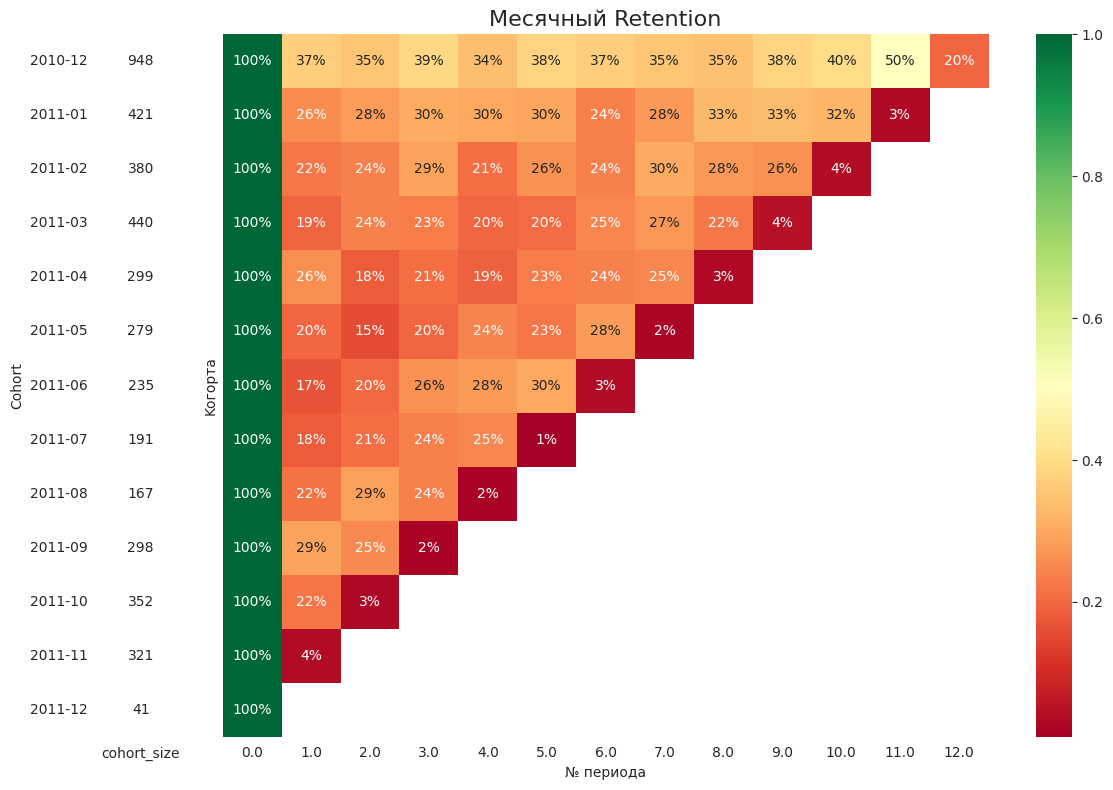

In [35]:
# Tепловая карта когортного анализа
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 2, figsize=(12,8), sharey=True,
                                        gridspec_kw={'width_ratios':[1,11]})

    # тепловая карта для коэффициента удержания
    sns.heatmap(df_retention,
               mask=df_retention.isnull(),
               annot=True,
               fmt='.0%',
               cmap='RdYlGn',
               ax=ax[1])
    ax[1].set_title('Месячный Retention', fontsize=16)
    ax[1].set(xlabel='№ периода', ylabel='Kогорта')

    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0:'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df,
               annot=True,
               cbar=False,
               fmt='g',
               cmap=white_cmap,
               ax=ax[0])

    fig.tight_layout()
    plt.show()